# Self-Driving Car Engineer Nanodegree

## Project Three

## Project: Behavioral Cloning

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import cv2
import numpy as np
import csv
from keras.models import Sequential,Model
from keras.layers import Flatten,Dense,Lambda,Conv2D,MaxPool2D,Cropping2D
from itertools import islice
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
###read data from csv
def getLinesFromDrivingLogs(dataPath, skipHeader=True):
    """
    Returns the lines from a driving log with base directory `dataPath`.
    If the file include headers, pass `skipHeader=True`.
    """
    lines = []
    with open(dataPath + '/driving.csv') as csvFile:
        reader = csv.reader(csvFile)
        if skipHeader:
            next(reader, None)
        for line in reader:
            lines.append(line)
    return lines
"""
data = getLinesFromDrivingLogs('data')
print(np.array(data).shape)
print(data[1][1].split('/')[-1])
"""

###find image name from driving.csv
def findImages(dataPath):
    """
    Finds all the images needed for training on the path `dataPath`.
    Returns `([centerPaths], [leftPath], [rightPath], [measurement])`
    """
    directories = [x[0] for x in os.walk(dataPath)]
    dataDirectories = list(filter(lambda directory: os.path.isfile(directory + '/driving.csv'), directories))
    centerTotal = []
    leftTotal = []
    rightTotal = []
    measurementTotal = []
    for directory in dataDirectories:
        lines = getLinesFromDrivingLogs(directory)
        print(lines[1][1].split('/')[-1])
        center = []
        left = []
        right = []
        measurements = []
        for line in lines:
            measurements.append(float(line[3]))
            center.append(directory + '/IMG/' + line[0].split('/')[-1])
            left.append(directory + '/IMG/' + line[1].split('/')[-1])
            right.append(directory + '/IMG/' + line[2].split('/')[-1])
        centerTotal.extend(center)
        leftTotal.extend(left)
        rightTotal.extend(right)
        measurementTotal.extend(measurements)

    return (centerTotal, leftTotal, rightTotal, measurementTotal)

#read img from path
def combineImages(center, left, right, measurement, correction):
    """
    Combine the image paths from `center`, `left` and `right` using the correction factor `correction`
    Returns ([imagePaths], [measurements])
    """
    imagePaths = []
    imagePaths.extend(center)
    imagePaths.extend(left)
    imagePaths.extend(right)
    measurements = []
    measurements.extend(measurement)
    measurements.extend([x + correction for x in measurement])#left angles
    measurements.extend([x - correction for x in measurement])
    return (imagePaths, measurements)

##the framework
##step 1
# Reading images locations.
centerPaths, leftPaths, rightPaths, measurements = findImages('Simdata/trackone')# call the function read csv data from driving.csv and get the path of img 
imagePaths, measurements = combineImages(centerPaths, leftPaths, rightPaths, measurements, 0.2)

print('Total Images: {}'.format( len(imagePaths)))

Using TensorFlow backend.


left_2017_10_24_16_38_46_464.jpg
Total Images: 20253


In [2]:
###python generator for decress the memory at same time
import sklearn

def generator(samples, batch_size=32):
    """
    Generate the required images and measurments for training/
    `samples` is a list of pairs (`imagePath`, `measurement`).
    """
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for imagePath, measurement in batch_samples:
                originalImage = cv2.imread(imagePath)
                image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)#opencv read the image by BGR ,so you have to change that.
                images.append(image)
                angles.append(measurement)
                # Flipping
                images.append(cv2.flip(image,1))
                angles.append(measurement*-1.0)

            # trim image to only see section with road
            inputs = np.array(images)
            outputs = np.array(angles)
            yield sklearn.utils.shuffle(inputs, outputs)

In [3]:
#just for validData 
#because of the visualize using tensorboard ,the validation data could not be a generator
def forValidData(samples):
   images = []
   angles = []
   for imagePath, measurement in samples:
     originalImage = cv2.imread(imagePath)
    # print(imagePath)
     image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
     images.append(image)
     angles.append(measurement)
     # Flipping
     images.append(cv2.flip(image,1))
     angles.append(measurement*-1.0)

     # trim image to only see section with road
   X_valid = np.array(images)
   y_valid = np.array(angles)
   return X_valid,y_valid

In [4]:
# Splitting samples and creating generators.
from sklearn.model_selection import train_test_split
samples = list(zip(imagePaths, measurements))
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print('Train samples: {}'.format(len(train_samples)))
print('Validation samples: {}'.format(len(validation_samples)))
###generator data
train_generator = generator(train_samples, batch_size=32)
X_valid,y_valid = forValidData(validation_samples)#just for validation
print('Train generator : {}'.format(np.array(train_generator).shape))
print('X Validation dataset :{}'.format(np.array(X_valid).shape))
print('Y Validation dataset :{}'.format(np.array(y_valid).shape))

Train samples: 16202
Validation samples: 4051
Train generator : ()
X Validation dataset :(8102, 160, 320, 3)
Y Validation dataset :(8102,)


---

## Step 1: Dataset Summary & Exploration

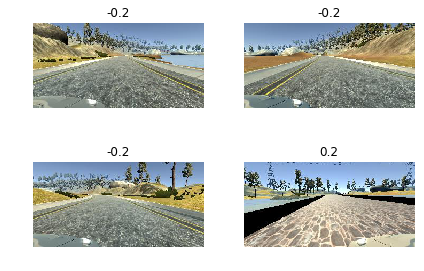

In [5]:
import matplotlib.pyplot as plt
import random

#visualize the data
fig, axs = plt.subplots(ncols = 2,nrows = 2,figsize=(6,4))
axs = axs.ravel()# packed as 1-D array
for i in range(4):
    index = random.randint(0,len(X_valid))
    axs[i].imshow(X_valid[index],plt.gray())
    axs[i].set_title(y_valid[index])
    axs[i].set_axis_off()#turn off
plt.tight_layout()


plt.show()

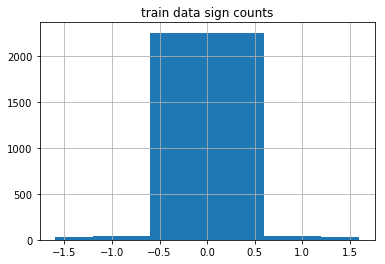

In [5]:
##hisgro
#visualize theamount of  data by bar
def Counts_bar(y_train,title):
    unique_train,counts_train = np.unique(y_train,return_counts=True)
   
    plt.bar(unique_train,counts_train)
    plt.grid()
    plt.title("%s data sign counts"%(title))
    plt.show()

#test function Counts_bar
Counts_bar(y_valid,'train')

----

## Step 2: Design and Test several Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Nvidia Model Architecture
##### pre-process data
In Keras, lambda layers can be used to create arbitrary functions that operate on each image as it passes through the layer.

In this project, a lambda layer is a convenient way to parallelize image normalization. The lambda layer will also ensure that the model will normalize input images when making predictions in drive.py.

That lambda layer could take each pixel in an image and run it through the formulas:

pixel_normalized = pixel / 255

pixel_mean_centered = pixel_normalized - 0.5

A lambda layer will look something like:

Lambda(lambda x: (x / 255.0) - 0.5)

Below is some example code for how a lambda layer can be used. 

In [7]:
###create model
import random
from keras.layers.core import Activation,Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
#build the nvidia model

def Nvidia():
    ch, row, col = 3, 160, 320
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 -1.,
                 input_shape=(row, col,ch)))
    model.add(Cropping2D(cropping=((50,20), (0,0))))
    model.add(Conv2D(24,(5,5), subsample=(2,2), activation='relu'))
    model.add(Conv2D(36,(5,5), subsample=(2,2), activation='relu'))
    model.add(Conv2D(48,(5,5), subsample=(2,2), activation='relu'))
    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(Flatten())
    #reduce one layer from nvidia network
    ##fully connected
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

/home/chenxingli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  
/home/chenxingli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  from ipykernel import kernelapp as app
/home/chenxingli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  app.launch_new_instance()


Epoch 1/5
507/506 [==============================] - 99s - loss: 0.0690 - acc: 0.2716 - val_loss: 0.0592 - val_acc: 0.2550
Epoch 2/5
507/506 [==============================] - 98s - loss: 0.0608 - acc: 0.2731 - val_loss: 0.0570 - val_acc: 0.2550
Epoch 3/5
507/506 [==============================] - 98s - loss: 0.0561 - acc: 0.2732 - val_loss: 0.0600 - val_acc: 0.2552
Epoch 4/5
507/506 [==============================] - 99s - loss: 0.0527 - acc: 0.2749 - val_loss: 0.0517 - val_acc: 0.2559
Epoch 5/5
507/506 [==============================] - 99s - loss: 0.0482 - acc: 0.2745 - val_loss: 0.0488 - val_acc: 0.2556
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


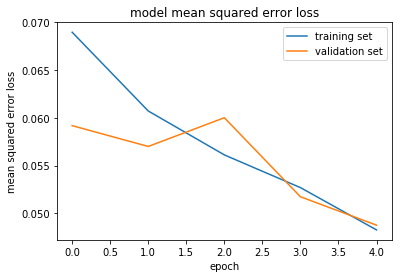

In [8]:
#train model and save the log for visualization
# Model creation
import keras
model = Nvidia()
#log path
log_filepath = './tmp/keras_log'
tb_cb = keras.callbacks.TensorBoard(log_dir=log_filepath,write_images=1, histogram_freq=1)
cbks =[tb_cb]
#train
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])#its a prediction model the last parameter is for visualization
history_object = model.fit_generator(train_generator, steps_per_epoch = len(train_samples)/32,
                                     validation_data = (X_valid,y_valid), validation_steps = len(validation_samples)/32,epochs=5, verbose=1,callbacks=cbks)
model.save('NvidiaModel2.h5')
##print the keys contained in the history object
print(history_object.history.keys())
##plot  loss the training and validation
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'],loc='upper right')
plt.show()
exit()